In [248]:
%load_ext autoreload
%aimport gtools, FakeDataMaker
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
import numpy as np
import iqtools as iq
import matplotlib.pyplot as plt
from lmfit import Model
import FakeDataMaker as fm
from gtools import get_dbm
from matplotlib.ticker import FormatStrFormatter
from datetime import datetime

%matplotlib inline

In [250]:
# isotope data
filename = '79as.csv'
save_flag = True

freq_dat, mom_dat, isotope_name = fm.import_data(filename, corrected=False)

In [251]:
imported_interp_data = np.transpose(np.genfromtxt('data/interp_single_sig.csv', delimiter=','))

In [252]:
xnew, interp_signal = imported_interp_data[0], imported_interp_data[1]

In [253]:
# fake rqmap
rqmap_x = np.linspace(-0.5, 0.5, int(1e6))
rqmap_z = np.linspace(180, 16, int(1e6))

In [254]:
gmodel = Model(fm.gaussian)
gresult_single_signal_fit = gmodel.fit(
    interp_signal,
    x=xnew,
    amp=4e-6,
    cen=xnew[np.argmax(interp_signal)],
    sigma=500,
    yoffset=3e-6,
)
gresult_single_signal_fit

In [255]:
interp_sig_center = gresult_single_signal_fit.params['cen'].value
interp_sig_sigma = gresult_single_signal_fit.params['sigma'].value

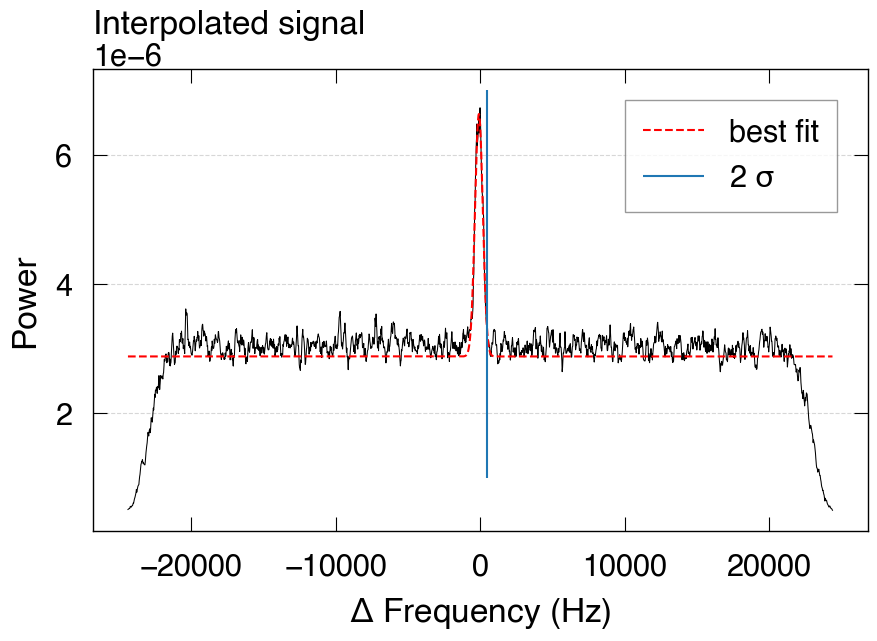

In [256]:
# figure - interpolated single signal
plt.style.use('/Users/gwgwhc/Documents/code/stylelib/ticksin_helvetica.mplstyle')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(
    xnew, interp_signal,
    color='black',
    linestyle='-',
    linewidth=0.75
)

# ax.plot(
#     xnew, gresult_single_signal_fit.init_fit,
#     color='green',
#     linewidth=0.75,
#     label='init fit'
# )

ax.plot(
    xnew, gresult_single_signal_fit.best_fit,
    color='red',
    linestyle='--',
    label='best fit'
)

ax.vlines(interp_sig_center+2*interp_sig_sigma, 1e-6, 7e-6, label='2 $\sigma$')

span1 = 5000
# ax.set_xlim(signal_center-span1, signal_center+span1)
# ax.set_ylim(-24, -14)

ax.set_title('Interpolated signal')
ax.set_xlabel('$\Delta$ Frequency (Hz)')
ax.set_ylabel('Power')

ax.legend()

plt.show()

In [257]:
# find zero index
zero_index = np.abs(xnew).argmin()
len_x = len(xnew)

In [258]:
# create fake frequency data to overlay peaks on
canvas_raw = np.linspace(np.mean(freq_dat)-len_x, np.mean(freq_dat)+len_x, len_x*4)

In [259]:
total_power_raw = fm.create_fake_data(canvas_raw, freq_dat, xnew, interp_signal, interp_sig_center)

In [260]:
# remove zero values
zero_indexes = np.where(total_power_raw == 0)
total_power = np.delete(total_power_raw, zero_indexes)
canvas = np.delete(canvas_raw, zero_indexes)

In [291]:
# fit params
span2 = int(1e4)
cen_bin = np.argmax(total_power)
cen2 = canvas[cen_bin]

In [262]:
# gaussian fit
gmodel = Model(fm.gaussian)
gresult = gmodel.fit(
    total_power[cen_bin-span2:cen_bin+span2],
    x=canvas[cen_bin-span2:cen_bin+span2],
    amp=4e-5,
    cen=canvas[np.argmax(total_power)],
    sigma=3e2,
    yoffset=4e-5
)

gresult.result

In [ ]:
if save_flag:
    # Write lmfit results to logfile
    with open(f'logs/{isotope_name}_stacked_peaks.log', 'w') as logfile:
        logfile.write(f"Fit results for {isotope_name} \n{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        logfile.write("=" * 40 + "\n")
        logfile.write("Gaussian Fit Results:\n")
        logfile.write(gresult.fit_report())
    # write data out
    with open (f'data_out/{isotope_name}_stacked_peaks.csv', 'w') as csvfile:
        for x, y in zip(canvas, total_power):
            csvfile.write(f"{x},{y}\n")

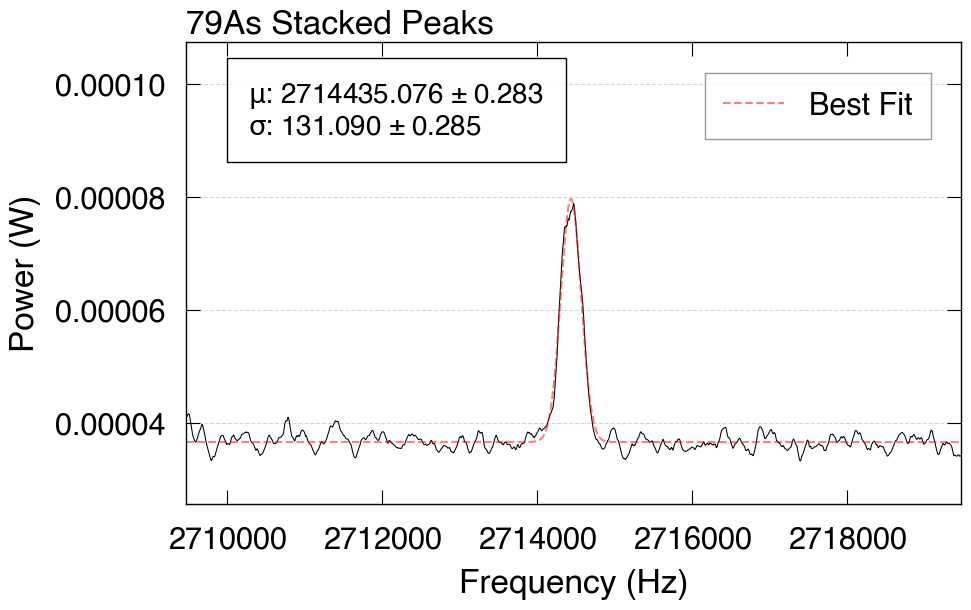

In [264]:
# figure - stacked peaks
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# signal
ax.plot(
    # canvas, gt.get_dbm(total_power),
    canvas, total_power,
    color='black',
    linestyle='-',
    linewidth=0.75
)

# best fit
ax.plot(
    canvas[cen_bin-span2:cen_bin+span2], gresult.best_fit,
    color='red',
    linestyle='--',
    label='Best Fit',
    alpha=0.5
)

# fit results text
cen_val, cen_err = gresult.params['cen'].value, gresult.params['cen'].stderr
sig_val, sig_err = gresult.params['sigma'].value, gresult.params['sigma'].stderr
ax.text(
    0.08, 0.8, 
    f'$\\mu$: {cen_val:0.3f} ± {cen_err:0.3f} \n$\\sigma$: {sig_val:0.3f} ± {sig_err:0.3f}',
    fontsize='small',
    transform = ax.transAxes, # relative coord scale
    bbox={"facecolor": (1,1,1,0.9), "pad": 15.0},
)

# center line
# ax.vlines(cen_val + 2*sig_val, 0, 8e-5)

ax.set_xlim(cen2-span2/2,cen2+span2/2)
ax.set_ylim((gresult.params['yoffset'].value*0.7), gresult.params['amp'].value*2.5)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

ax.set_title(f'{isotope_name} Stacked Peaks')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (W)')

ax.legend()

if save_flag:
    plt.savefig(f'plots/stacked_peaks/{isotope_name}_stacked_peaks.pdf', bbox_inches='tight')

In [265]:
elliptical_signal = fm.create_fake_elliptical_data(
    canvas_raw,
    freq_dat,
    mom_dat,
    xnew,
    interp_signal,
    interp_sig_center,
    interp_sig_sigma,
    rqmap_x,
    rqmap_z
)

In [281]:
# remove zero values
zero_indexes_elliptical = np.where(elliptical_signal == 0)
total_power_elliptical = np.delete(elliptical_signal, zero_indexes)
canvas_elliptical = np.delete(canvas_raw, zero_indexes)

In [284]:
gresult_elliptical = gmodel.fit(
    total_power_elliptical[cen_bin-span2:cen_bin+span2],
    x=canvas_elliptical[cen_bin-span2:cen_bin+span2],
    amp=4e-5,
    cen=canvas[np.argmax(total_power)],
    sigma=3e2,
    yoffset=4e-5
)


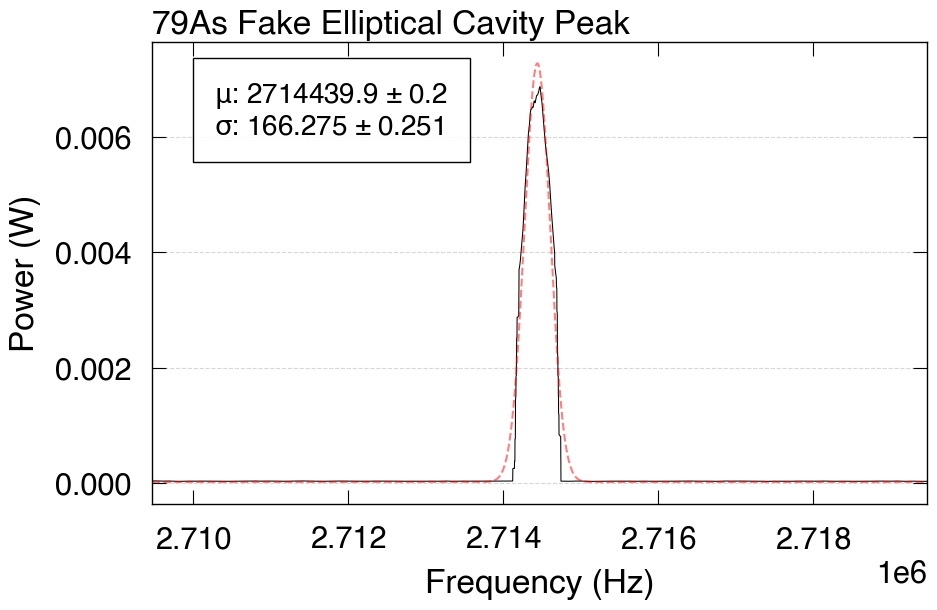

In [290]:
# figure - stacked peaks
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# signal
ax.plot(
    canvas_elliptical, total_power_elliptical,
    color='black',
    linewidth=0.75
)

# best fit
ax.plot(
    canvas[cen_bin-span2:cen_bin+span2], gresult_elliptical.best_fit,
    color='red',
    linestyle='--',
    label='Best Fit',
    alpha=0.5
)

# fit results text
cen_val, cen_err = gresult_elliptical.params['cen'].value, gresult_elliptical.params['cen'].stderr
sig_val, sig_err = gresult_elliptical.params['sigma'].value, gresult_elliptical.params['sigma'].stderr
ax.text(
    0.08, 0.8, 
    f'$\\mu$: {cen_val:0.1f} ± {cen_err:0.1f} \n$\\sigma$: {sig_val:0.3f} ± {sig_err:0.3f}',
    fontsize='small',
    transform = ax.transAxes, # relative coord scale
    bbox={"facecolor": (1,1,1,0.9), "pad": 15.0},
)

ax.set_xlim(cen2-span2/2,cen2+span2/2)
# ax.set_ylim((gresult.params['yoffset'].value*0.7), gresult.params['amp'].value*2.5)

# ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

# ax.set_yscale('log')

ax.set_title(f'{isotope_name} Fake Elliptical Cavity Peak')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (W)')

# ax.legend()

if save_flag:
    plt.savefig(f'plots/stacked_peaks/{isotope_name}_stacked_peaks.pdf', bbox_inches='tight')

In [293]:
if save_flag:
    # Write lmfit results to logfile
    with open(f'logs/{isotope_name}_stacked_peaks_elliptical.log', 'w') as logfile:
        logfile.write(f"Fit results for {isotope_name} (elliptical cav data) \n{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        logfile.write("=" * 40 + "\n")
        logfile.write("Gaussian Fit Results:\n")
        logfile.write(gresult_elliptical.fit_report())
    # write data out
    with open (f'data_out/{isotope_name}_stacked_peaks_elliptical.csv', 'w') as csvfile:
        for x, y in zip(canvas_elliptical, total_power_elliptical):
            csvfile.write(f"{x},{y}\n")

In [ ]:
# now make 2000 particles with distribution matching initial signal's distribution.
f_distribution = [np.random.normal(np.mean(freq_dat), gresult.params['sigma'].value) for i in range(2000)]
power_distribution = fm.create_fake_data(canvas_raw, f_distribution, xnew, interp_signal, interp_sig_center)


In [ ]:
cen_bin_dist = np.argmax(power_distribution)

In [ ]:
gresult_distribution = gmodel.fit(
    power_distribution[cen_bin_dist-span2:cen_bin_dist +span2],
    x=canvas_raw[cen_bin_dist-span2:cen_bin_dist+span2],
    amp=1e-2,
    cen=canvas_raw[np.argmax(power_distribution)],
    sigma=3e2,
    yoffset=5e-3
)

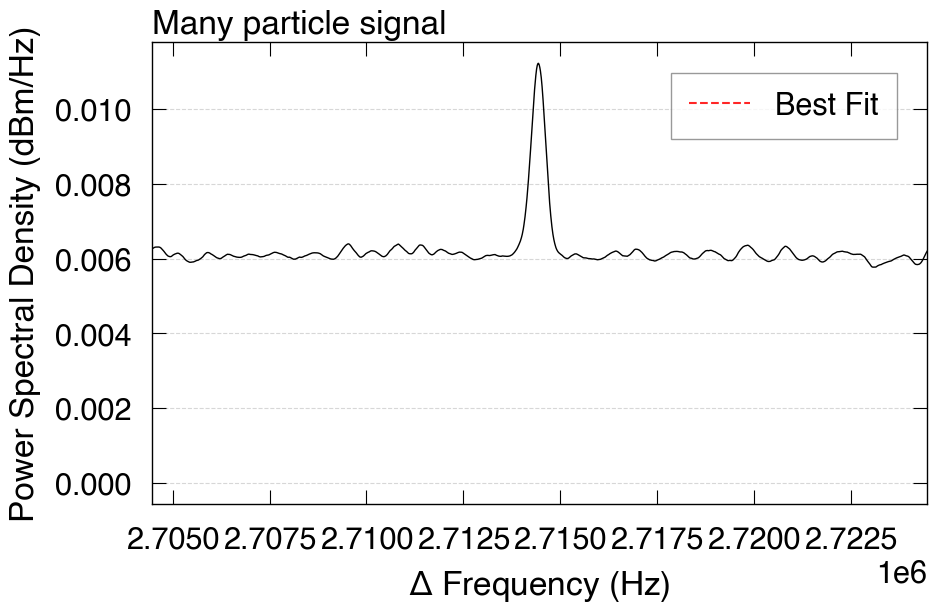

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(
    canvas_raw, power_distribution,
    color='black',
    linestyle='-',
    linewidth=1
)

# ax.plot(
#     canvas_raw[cen_bin-span2:cen_bin+span2], gresult_distribution.init_fit,
#     color='green',
#     linestyle='--',
#     label='Init Fit',
# )

ax.plot(
    canvas_raw[cen_bin-span2:cen_bin+span2], gresult_distribution.best_fit,
    color='red',
    linestyle='--',
    alpha=0.85,
    label='Best Fit',
)

ax.set_xlim(cen2-span2,cen2+span2)
# ax.set_yscale('log')
ax.vlines(canvas_raw[cen_bin], 0, 8e-5)

ax.set_title('Many particle signal')
ax.set_xlabel('$\Delta$ Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dBm/Hz)')

ax.legend()

In [ ]:
gresult_distribution.result